### Markov Chain Attribution Modelling
An approach that models the customer journey as a Markov chain. A Markov chain is a mathematical model that represents a sequence of events where the probability of transitioning from one state to another depends only on the current state and not on the previous states.

In the context of attribution modeling, the states represent different touchpoints or marketing channels, and the transitions represent the movement of customers from one touchpoint to another. The **goal is to understand the probability distribution of transitions between touchpoints and use it to assign credit for conversions.**

In marketing it allows answering the following question:
- “If channel X were not present in my marketing strategy, what would be the effect on the probability of conversion?“

This will give a `removal effect` for each channel and through that marketing teams can decide **which channels are the most important.**

Take a look at the following example:

<div style="text-align:center">
    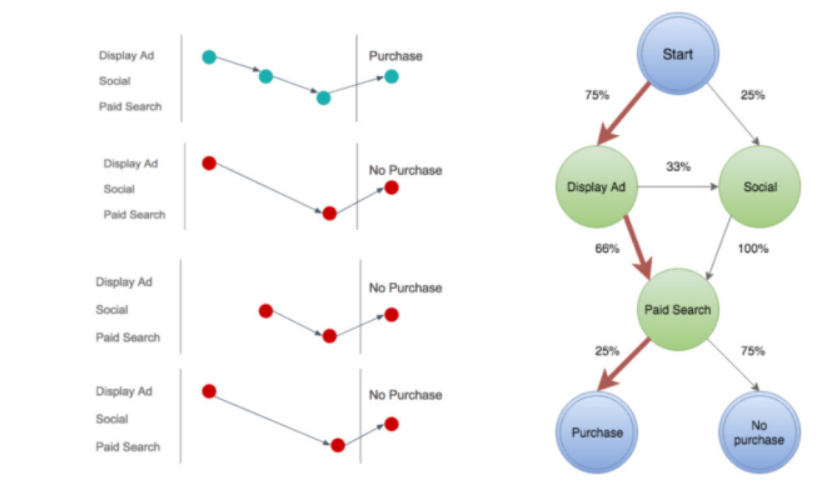
</div>

### What is Markov Chain Order?
The order of the Markov chains **defines how many observations we are looking at before the future one** - so in the case of the second order, we are checking two observations

<div style="text-align:center">
    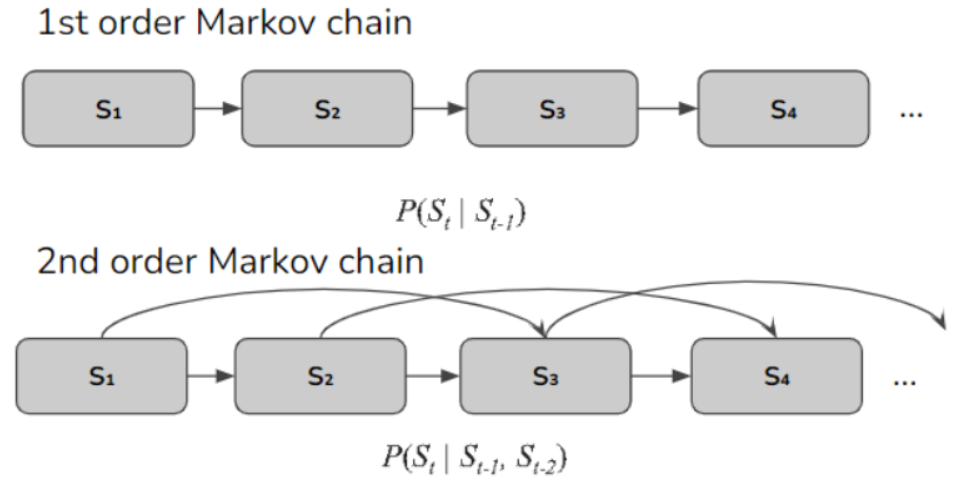
</div>

### Digital Marketing Attribution Use Case
Let's try to build a baseline model to estimate attribution of different channels. We will need the following library:
- https://pypi.org/project/ChannelAttribution/

**Data Description**

The data set contains of 586k marketing touch-points with 240k unique customers who generated 18k conversions (one month data)

- `Cookie:` 
    - Anonymous customer id enabling us to track the progression of a given customer. For simplicity we consider that each unique cookie describes a one unique user. However, it might not be the case.
<br><br>
- `Timestamp:`
    - Date and time when the visit took place.
<br><br>
- `Interaction:`
    - Categorical variable indicating the type of interaction (conversion or impression).
<br><br>
- `Conversion:`
    - Boolean variable indicating whether a conversion took place.
<br><br>
- `Conversion Value:`
    - Value of the potential conversion event (revenue).
<br><br>
- `Channel:`
    - The marketing channel that brought the customer to the main site

In [1]:
import pandas as pd
import numpy as np
import warnings

import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns

from ChannelAttribution import *

warnings.filterwarnings('ignore')

In [2]:
data = pd.read_csv('../data/channel_attribution_data.csv', parse_dates=['time'])
data.head()

,cookie,time,interaction,conversion,conversion_value,channel
0,00000FkCnDfDDf0iC97iC703B,2018-07-03 13:02:11+00:00,impression,0,0.0,Instagram
1,00000FkCnDfDDf0iC97iC703B,2018-07-17 19:15:07+00:00,impression,0,0.0,Online Display
2,00000FkCnDfDDf0iC97iC703B,2018-07-24 15:51:46+00:00,impression,0,0.0,Online Display
3,00000FkCnDfDDf0iC97iC703B,2018-07-29 07:44:51+00:00,impression,0,0.0,Online Display
4,0000nACkD9nFkBBDECD3ki00E,2018-07-03 09:44:57+00:00,impression,0,0.0,Paid Search


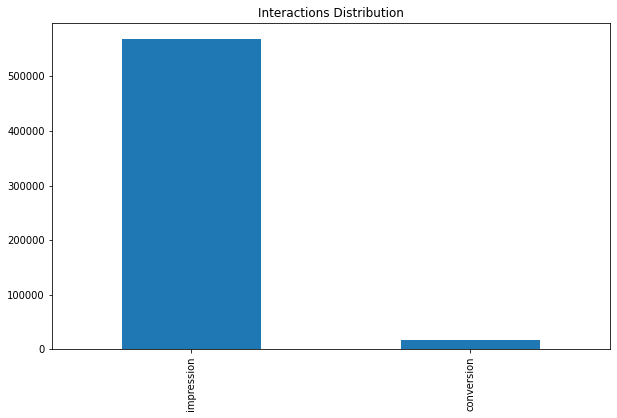

In [3]:
data['interaction'].value_counts().plot(kind='bar', figsize=(10, 6), title='Interactions Distribution');

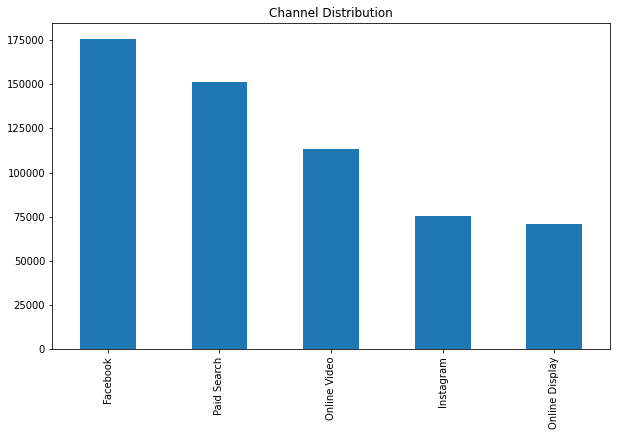

In [4]:
data['channel'].value_counts().plot(kind='bar', figsize=(10, 6), title='Channel Distribution');

**Insights**
- `Facebook` and `Paid Search` are the most used channels

In [5]:
# add date column
data['date'] = data['time'].dt.date

# select conversions and aggregate
conversions_df = data[data['conversion'] == 1]
columns_to_drop = ['cookie', 'interaction']

conversions_agg = conversions_df.drop(columns_to_drop, axis='columns')
conversions_agg = conversions_agg.groupby(['date','channel'], as_index=False).sum()
conversions_agg.head()

,date,channel,conversion,conversion_value
0,2018-07-01,Facebook,135,835.0
1,2018-07-01,Instagram,69,438.5
2,2018-07-01,Online Display,75,463.5
3,2018-07-01,Online Video,42,257.5
4,2018-07-01,Paid Search,98,590.5


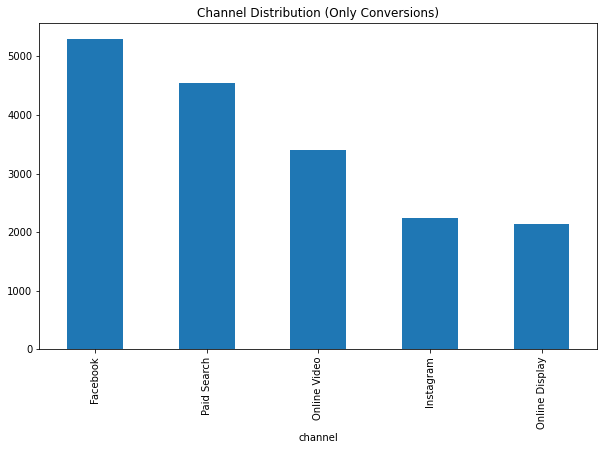

In [6]:
# what is the most successful channel that drives conversions
channels_conv_agg = conversions_agg.groupby('channel').sum().sort_values(by='conversion', ascending=False)
channels_conv_agg['conversion'].plot(kind='bar', figsize=(10, 6), title='Channel Distribution (Only Conversions)');

**Insights**
- Facebook and Paid Seach are again the most important channels that drive conversions

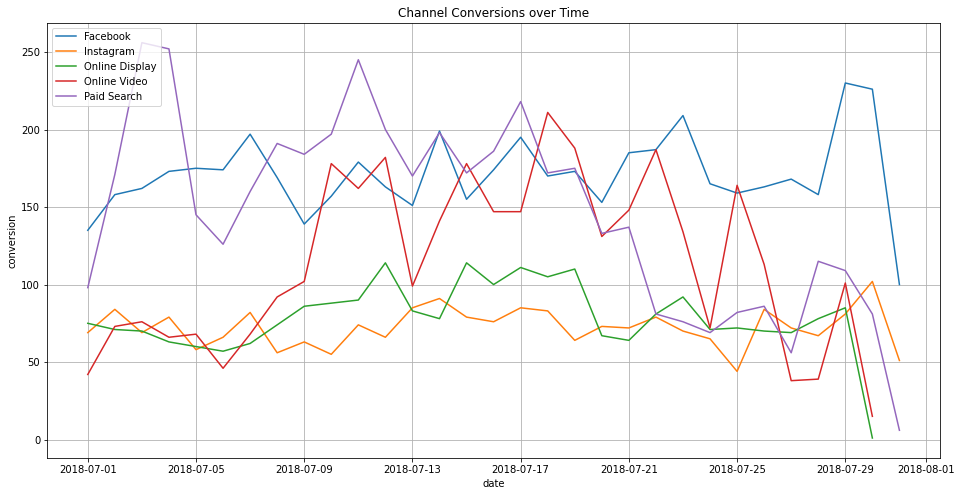

In [7]:
plt.figure(figsize=(16,8))
sns.lineplot(x='date', y='conversion', hue='channel', data=conversions_agg)
plt.title('Channel Conversions over Time')
plt.grid()
plt.legend(loc='upper left');

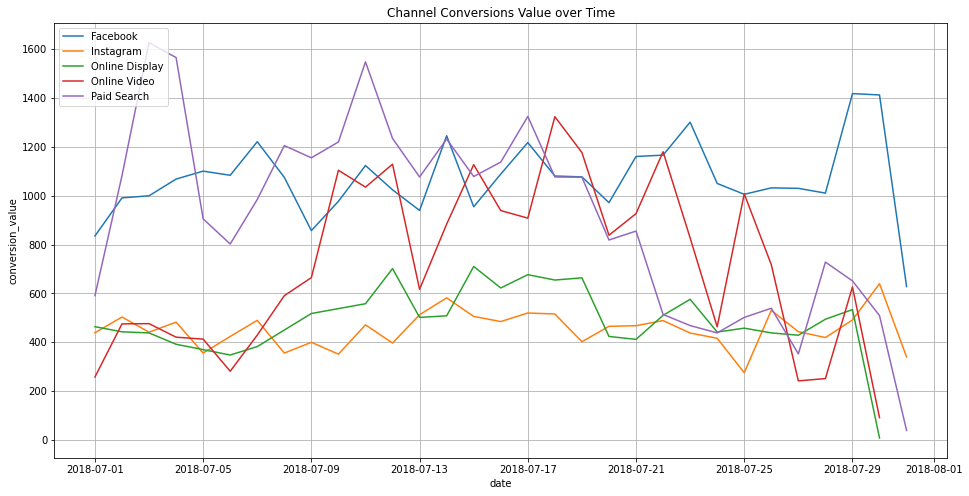

In [8]:
plt.figure(figsize=(16,8))
sns.lineplot(x='date', y='conversion_value', hue='channel', data=conversions_agg)
plt.title('Channel Conversions Value over Time')
plt.grid()
plt.legend(loc='upper left');

**Insights**
- Looks like `Instagram` and `Online Display` are the main outsiders in terms of conversion value
- `Paid Search` and `Facebook` are the best in terms of conversion value
- `Online Video` is in the middle between outsiders and leaders

### User Journeys
Let's take a look at user journeys distribution. Probably it will have long right tail since the **majority of users usually have a few interactions**

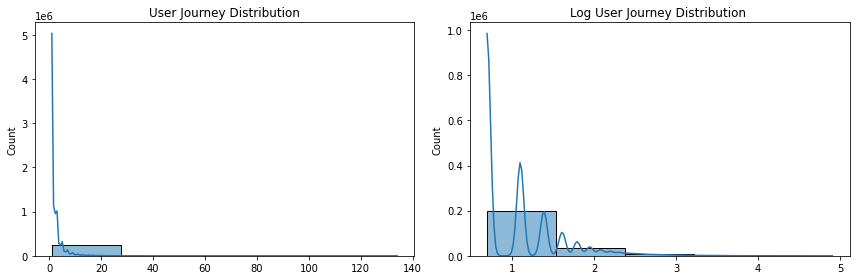

In [9]:
user_journey_dist = data['cookie'].value_counts()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,4))

user_journey_original = user_journey_dist.values
user_journey_log = np.log(user_journey_dist.values + 1) # add 1 because log(0) is undefined

ax1 = sns.histplot(user_journey_original, kde=True, ax=ax1, bins=5)
ax1.set_title("User Journey Distribution")
ax1.figure.tight_layout()

ax2 = sns.histplot(user_journey_log, kde=True, ax=ax2, bins=5)
ax2.set_title("Log User Journey Distribution ")
ax2.figure.tight_layout()

Let's **compare user journey length for conversion and non conversion group**

In [10]:
conversion_gr = data[data['conversion'] == 1]
non_conversion_gr = data[data['conversion'] == 0]

uj_conversion_dist = conversion_gr['cookie'].value_counts()
uj_non_conversion_dsit = non_conversion_gr['cookie'].value_counts()

In [11]:
display(
    pd.DataFrame(uj_conversion_dist).describe().T,
    pd.DataFrame(uj_non_conversion_dsit).describe().T
)

,count,mean,std,min,25%,50%,75%,max
cookie,17639.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0


,count,mean,std,min,25%,50%,75%,max
cookie,232691.0,2.445724,3.106346,1.0,1.0,1.0,3.0,133.0


**Insights**
- All **user from conversion group have only 1 interaction** (probably it was done on purpose -> artificial data)

In [12]:
n_conversions = data['conversion'].sum()
conversion_value_total = data['conversion_value'].sum()

print('N Conversions: ', n_conversions)
print('Conversion Rate: ', round(n_conversions / data.shape[0]*100, 2))
print('Total Conversion Value: ', conversion_value_total)
print('Avg Conversion Value: ', round(conversion_value_total / n_conversions, 2))

N Conversions:  17639
Conversion Rate:  3.01
Total Conversion Value:  110231.0
Avg Conversion Value:  6.25


### Data Preprocessing
In order to build a Markov Chain model **we need to transform the raw data into required input.** Basically, we need to create all possible 
combinations of touchpoints (user journeys) that led to conversion (conversion user journeys -> only those user journeys that led to a conversion).

In [13]:
# single user journey example
data[data['cookie'] == '00000FkCnDfDDf0iC97iC703B']

,cookie,time,interaction,conversion,conversion_value,channel,date
0,00000FkCnDfDDf0iC97iC703B,2018-07-03 13:02:11+00:00,impression,0,0.0,Instagram,2018-07-03
1,00000FkCnDfDDf0iC97iC703B,2018-07-17 19:15:07+00:00,impression,0,0.0,Online Display,2018-07-17
2,00000FkCnDfDDf0iC97iC703B,2018-07-24 15:51:46+00:00,impression,0,0.0,Online Display,2018-07-24
3,00000FkCnDfDDf0iC97iC703B,2018-07-29 07:44:51+00:00,impression,0,0.0,Online Display,2018-07-29


**Insights**
- This user had 4 interactions with 2 different channels (Instagram and Online Display) with no conversion in the end

In [14]:
# create path_order column
data['step_index'] = data.sort_values(['time']).groupby(['cookie']).cumcount() + 1
data.head()

,cookie,time,interaction,conversion,conversion_value,channel,date,step_index
0,00000FkCnDfDDf0iC97iC703B,2018-07-03 13:02:11+00:00,impression,0,0.0,Instagram,2018-07-03,1
1,00000FkCnDfDDf0iC97iC703B,2018-07-17 19:15:07+00:00,impression,0,0.0,Online Display,2018-07-17,2
2,00000FkCnDfDDf0iC97iC703B,2018-07-24 15:51:46+00:00,impression,0,0.0,Online Display,2018-07-24,3
3,00000FkCnDfDDf0iC97iC703B,2018-07-29 07:44:51+00:00,impression,0,0.0,Online Display,2018-07-29,4
4,0000nACkD9nFkBBDECD3ki00E,2018-07-03 09:44:57+00:00,impression,0,0.0,Paid Search,2018-07-03,1


**Important**

Conversion may happen at any place and time in a user journey. Besides, it may happen many or several times.

In [15]:
# check how many conversions each user has 
user_conversions = (
    data
        .groupby('cookie', as_index=False)['conversion']
        .sum()
        .sort_values('conversion', ascending=False)
)

user_conversions.head()

,cookie,conversion
38599,7FChE0hBikFnnDDnED3k3FiEA,1
55728,9hkhFkfBE7B0nAF9EACCfFFf7,1
76718,B7AAB99CCF7hBE33BF30ihD0B,1
212001,n70DCoEA0A3ihon99F3f0E9k3,1
111546,DD7hBk9oCAoDf3o9DC90ECoh9,1


**Assumption**

We see that **each user has only one conversion,** this again probably proves that this is toy dataset. For the current dataset there is no need to create sub sequences that led to conversions. For example, for this touchpoint sequence:
- `A -> C -> B -> A -> Conversion`
    - `A -> C -> B -> A`
<br><br>
- `A -> B -> C -> Conversion_1 -> C -> B -> A -> Conversion_2 -> C -> A -> Conversion_3`
    - `A -> B -> C`
    - `C -> B -> A`
    - `C -> A`
    - `A -> B -> C -> B -> A`
    - `A -> B -> C -> B -> A -> C -> A`

In [16]:
# get user journeys 
user_journeys = data.groupby('cookie')['channel'].agg(lambda x: ' > '.join(x.tolist())).reset_index()
user_journeys = user_journeys.rename(columns={"channel": "user_journey"})
user_journeys.head()

,cookie,user_journey
0,00000FkCnDfDDf0iC97iC703B,Instagram > Online Display > Online Display > ...
1,0000nACkD9nFkBBDECD3ki00E,Paid Search > Paid Search > Paid Search > Paid...
2,0003EfE37E93D0BC03iBhBBhF,Paid Search > Paid Search > Paid Search > Paid...
3,00073CFE3FoFCn70fBhB3kfon,Instagram
4,00079hhBkDF3k3kDkiFi9EFAD,Paid Search


Since the conversion could only happen at the end of journey, join results from the last interaction for each sequence.

We need it to estimate **if the observed touchpoint sequence led to a conversion in the end.**

In [17]:
# take a look at the last interaction (check if it led to conversion)
columns = [
    'cookie', 
    'conversion', 
    'conversion_value'
]

last_conversion = data.drop_duplicates('cookie', keep='last')[columns].rename(
    {
        'conversion': 'led_to_conversion',
        'conversion_value': 'conversion_value' # if led to conversion, what conversion value it was
    },
    axis='columns'
)

user_journeys = user_journeys.merge(last_conversion, how='left', on='cookie')
user_journeys.head()

,cookie,user_journey,led_to_conversion,conversion_value
0,00000FkCnDfDDf0iC97iC703B,Instagram > Online Display > Online Display > ...,0,0.0
1,0000nACkD9nFkBBDECD3ki00E,Paid Search > Paid Search > Paid Search > Paid...,0,0.0
2,0003EfE37E93D0BC03iBhBBhF,Paid Search > Paid Search > Paid Search > Paid...,0,0.0
3,00073CFE3FoFCn70fBhB3kfon,Instagram,0,0.0
4,00079hhBkDF3k3kDkiFi9EFAD,Paid Search,0,0.0


let's check how many times a specific combination of channels led to a conversion or null outcome

In [20]:
attribution_df = user_journeys.drop('cookie', axis='columns')
attribution_df['no_conversion'] = np.where(attribution_df['led_to_conversion'] == 0, 1, 0)

attribution_df = attribution_df.groupby(['user_journey'], as_index=False).sum()
attribution_df

,user_journey,led_to_conversion,conversion_value,no_conversion
0,Facebook,2054,12857.0,32802
1,Facebook > Facebook,538,3295.0,7410
2,Facebook > Facebook > Facebook,230,1458.0,2066
3,Facebook > Facebook > Facebook > Facebook,85,542.5,751
4,Facebook > Facebook > Facebook > Facebook > Fa...,41,255.5,318
...,...,...,...,...
11369,Paid Search > Paid Search > Paid Search > Paid...,1,6.0,0
11370,Paid Search > Paid Search > Paid Search > Paid...,0,0.0,1
11371,Paid Search > Paid Search > Paid Search > Paid...,0,0.0,1
11372,Paid Search > Paid Search > Paid Search > Paid...,0,0.0,1


### Attribution Modelling
Let's build several models (rule-based and data-driven)

In [20]:
# get attribution values based on heuristics (First Touc, Last Touch, ...)
heuristic_attribution = heuristic_models(
    Data=attribution_df,
    var_path='user_journey',
    var_conv='led_to_conversion', # conversions attribution
    var_value='conversion_value', # revenue attribution
    sep='>',
    flg_adv=False
)

# get attribution values based on Markov Chain model
markov_chain_attribution = markov_model(
    Data=attribution_df,
    var_path='user_journey',
    var_conv='led_to_conversion',
    var_value='conversion_value',
    order=1,
    sep='>',
    ncore=2,
    nfold=10,
    seed=23,
    flg_adv=False
)

Number of simulations: 100000 - Convergence reached: 1.59% < 5.00%
Percentage of simulated paths that successfully end before maximum number of steps (48) is reached: 99.99%


In [21]:
heuristic_attribution

,channel_name,first_touch_conversions,first_touch_value,last_touch_conversions,last_touch_value,linear_touch_conversions,linear_touch_value
0,Facebook,5177.0,32283.0,5301.0,33143.5,5218.903371,32614.300094
1,Instagram,2329.0,14579.5,2244.0,14039.5,2265.179353,14171.723842
2,Online Display,2160.0,13419.0,2139.0,13298.5,2124.315256,13205.187068
3,Online Video,3216.0,20225.5,3408.0,21418.0,3349.403371,21045.330408
4,Paid Search,4757.0,29724.0,4547.0,28331.5,4681.198650,29194.458588


In [22]:
markov_chain_attribution = markov_chain_attribution.rename({
    'total_conversions': 'markov_conversions',
    'total_conversion_value': 'markov_conversion_value'
}, axis='columns')

markov_chain_attribution

,channel_name,markov_conversions,markov_conversion_value
0,Facebook,5248.567310,32830.147327
1,Instagram,3459.695753,21631.953547
2,Online Video,2868.323874,17988.895756
3,Paid Search,4048.797490,25248.564746
4,Online Display,2013.615573,12531.438624


In [23]:
attribution_summary = pd.merge(
    heuristic_attribution,
    markov_chain_attribution,
    on="channel_name",
    how="inner"
)

# how many conversions were attributed to each channel depending on different type of model
conversions_columns = [
    'channel_name',
    'first_touch_conversions',
    'last_touch_conversions',
    'linear_touch_conversions',
    'markov_conversions'
]

importance_coumns = [
    'channel_name',
    'first_touch_value',
    'last_touch_value',
    'linear_touch_value',
    'markov_conversion_value'
]

attribution_summary_conversions = attribution_summary[conversions_columns]
attribution_summary_importance = attribution_summary[importance_coumns]

attribution_summary_conversions_melted = pd.melt(attribution_summary_conversions, id_vars="channel_name")
attribution_summary_importance_melted = pd.melt(attribution_summary_importance, id_vars="channel_name")

In [24]:
attribution_summary_conversions_melted.head()

,channel_name,variable,value
0,Facebook,first_touch_conversions,5177.0
1,Instagram,first_touch_conversions,2329.0
2,Online Display,first_touch_conversions,2160.0
3,Online Video,first_touch_conversions,3216.0
4,Paid Search,first_touch_conversions,4757.0


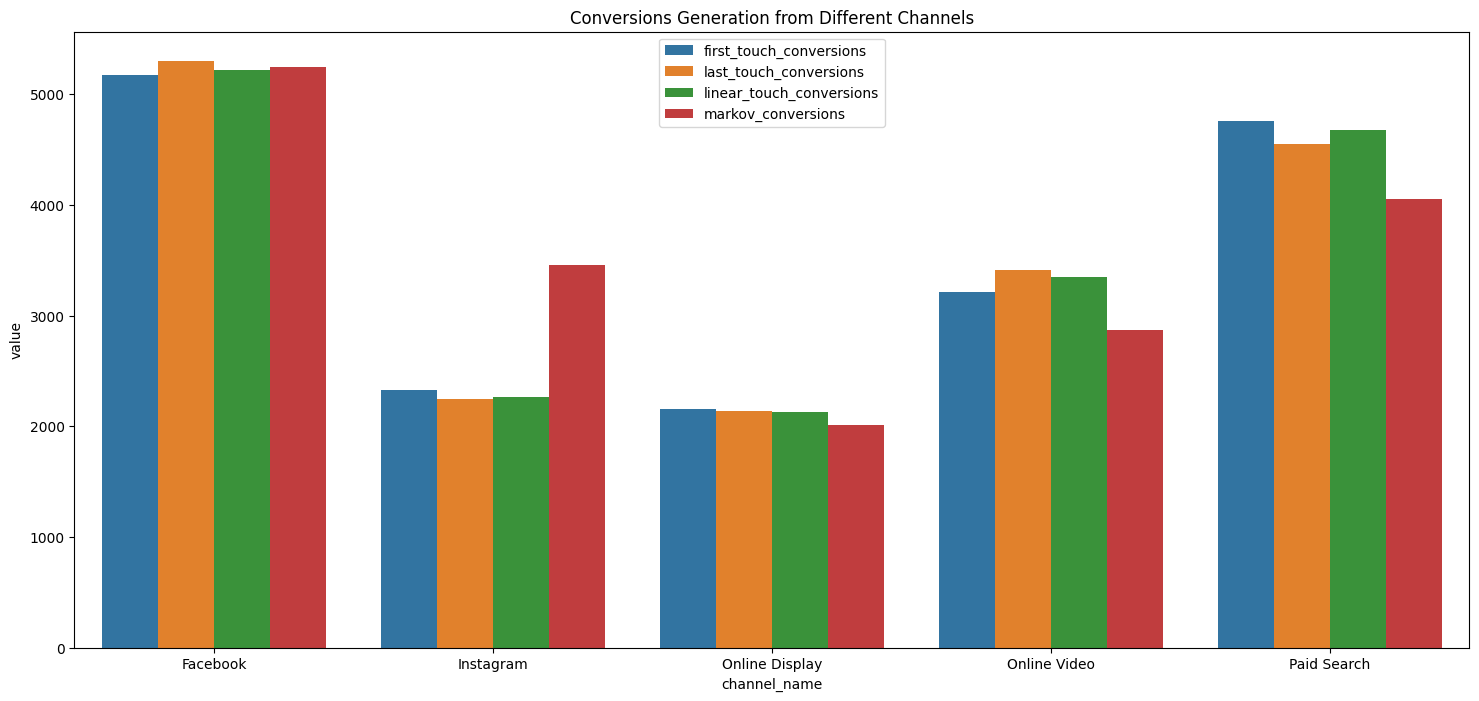

In [25]:
plt.figure(figsize=(18,8))

sns.barplot(
    data=attribution_summary_conversions_melted,
    x="channel_name", y='value', hue="variable",
)

plt.title('Conversions Generation from Different Channels')
plt.legend(loc='best');

**Interpretation**

`Facebook` and `Paid Search` are the most import channels driving conversions while `Instagram` and `Online Display` are the least important. However, according to the Markov Model, `Instagram` is far more important to our conversions than our simple attribution models suggest - indeed according to the probabilistic model it is in fact our **third most important channel.**

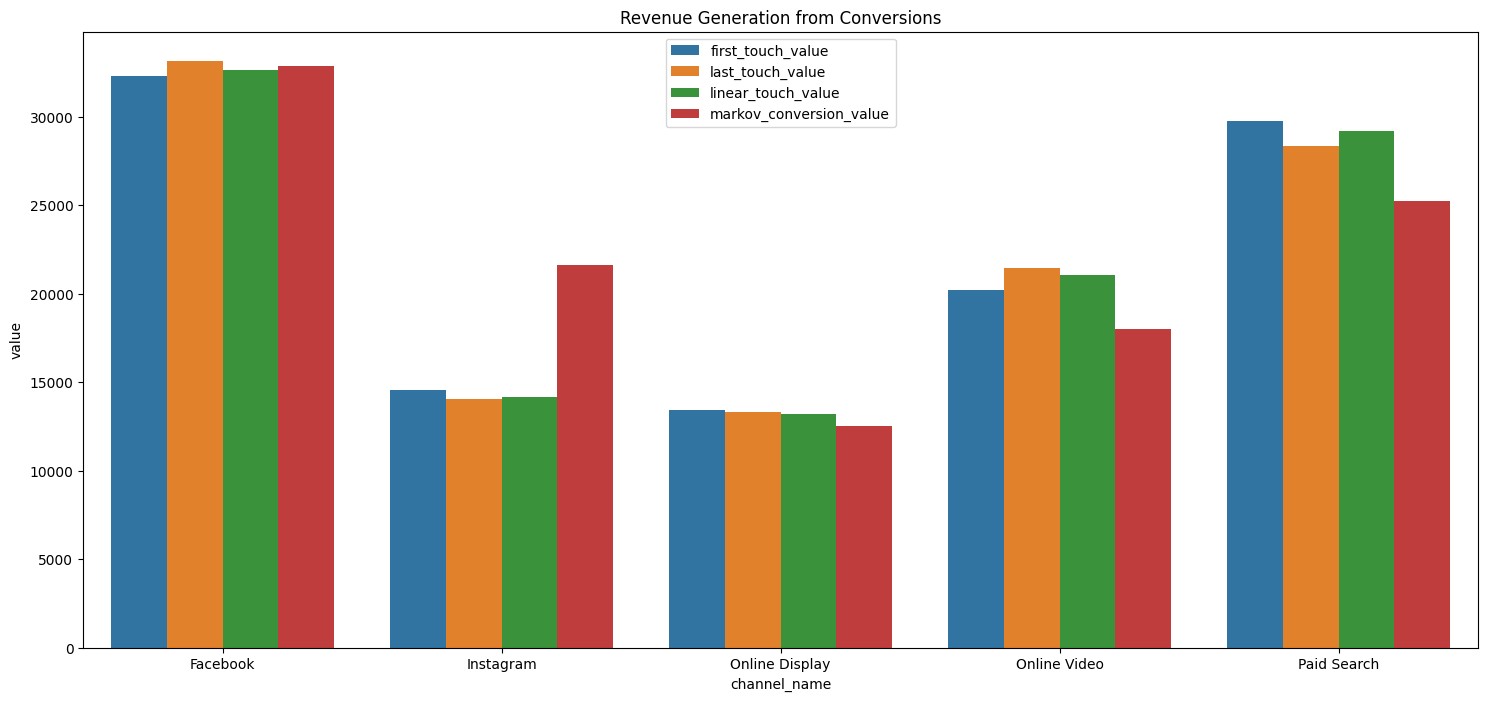

In [26]:
# create revenue attribution plot
plt.figure(figsize=(18,8))

sns.barplot(
    data=attribution_summary_importance_melted,
    x="channel_name", y='value', hue="variable",
)

plt.title('Revenue Generation from Conversions')
plt.legend(loc='best');

### Transition Matrix
To get an idea of channels interactiosn and likelihood of a transition from one state to another one, build a transition matrix

In [54]:
# create transition matrix
result = transition_matrix(
    attribution_df,
    "user_journey",
    "led_to_conversion",
    var_null="no_conversion",
    flg_adv=False
)

matrix = result['transition_matrix']
matrix.head()

,channel_from,channel_to,transition_probability
0,(start),1,0.278408
1,(start),2,0.119188
2,(start),3,0.142644
3,(start),4,0.142361
4,(start),5,0.317399


In [56]:
matrix = pd.pivot_table(
    matrix,
    values='transition_probability',
    index=['channel_from'],
    columns=['channel_to'],
    aggfunc=np.sum
)

column_dict = result['channels'].set_index('id_channel')['channel_name'].to_dict()
keys_values = column_dict.items()
column_dict = {str(key): str(value) for key, value in keys_values}

matrix = matrix.rename(mapper=column_dict, axis=1).rename(mapper=column_dict, axis=0)
matrix.fillna(0, inplace = True)

matrix

channel_to,(conversion),(null),Facebook,Instagram,Online Display,Online Video,Paid Search
channel_from,,,,,,,
(start),0.000000,0.000000,0.278408,0.119188,0.142644,0.142361,0.317399
Facebook,0.030164,0.363108,0.373140,0.159394,0.018197,0.021987,0.034010
Instagram,0.029840,0.363772,0.372522,0.159586,0.018683,0.022247,0.033351
Online Display,0.030104,0.457025,0.048992,0.021069,0.349007,0.016453,0.077351
Online Video,0.030079,0.280030,0.034765,0.014492,0.009894,0.606062,0.024677
Paid Search,0.030025,0.443073,0.052054,0.022656,0.041475,0.024736,0.385981


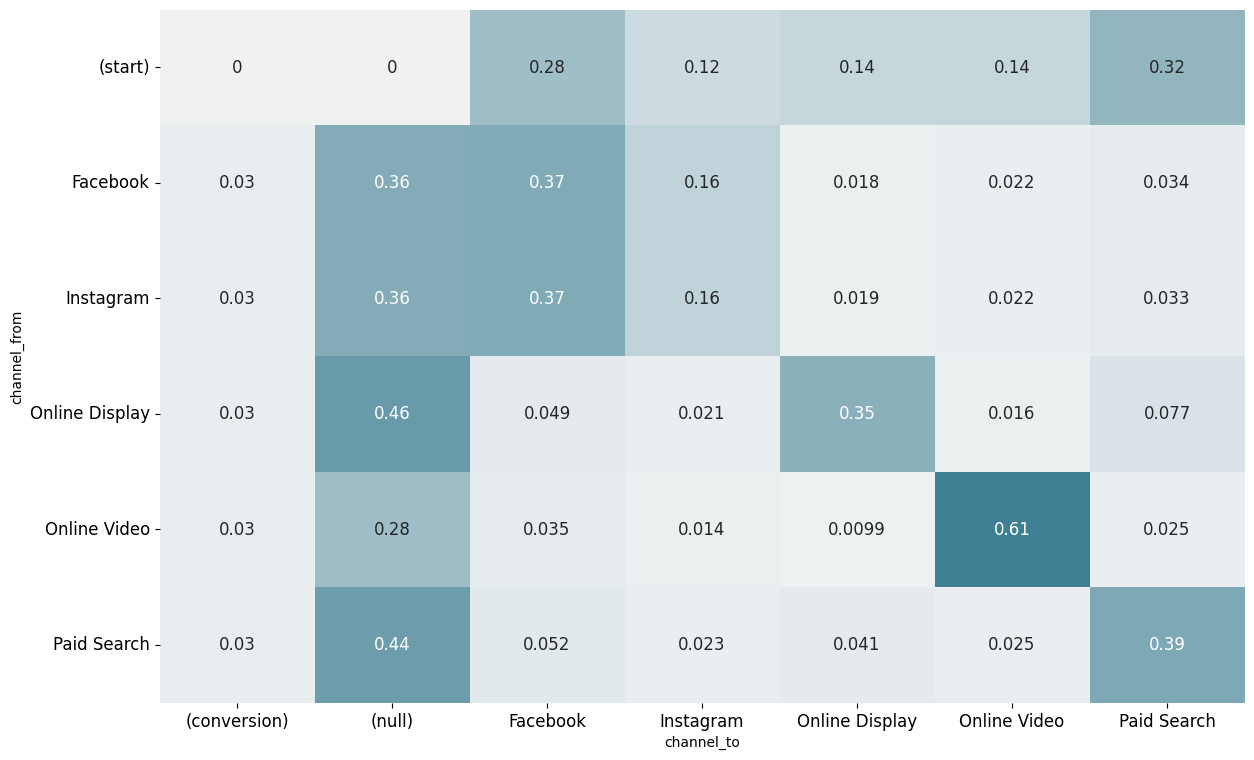

In [58]:
# plot transition probabilities
fig = plt.figure(figsize = (14,9))

sns.heatmap(
    matrix,
    cmap=sns.diverging_palette(20, 220, n=200),
    annot=True,
    center = 0,
    annot_kws={'size':12},
    cbar=False
)
plt.yticks(rotation=0, fontsize = 12)
plt.xticks(fontsize = 12);

### Reference
- https://www.kaggle.com/code/hughhuyton/multitouch-attribution-modelling
- https://github.com/DP6/Marketing-Attribution-Models
- https://medium.com/dp6-us-blog/multi-touch-attribution-optimizing-online-media-investment-with-data-science-c45b8b5181b4
- https://www.kaggle.com/datasets/akashdave/marketing-cost-attribution/data
- https://github.com/camille-004/attribution-modeling
- https://github.com/station-10/awesome-marketing-machine-learning